In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


tf.__version__

2023-04-14 10:30:18.388118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 10:30:18.471328: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-14 10:30:18.880461: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-14 10:30:18.880502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,2,484.4822,350.23
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,774.6917,347.50
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,4,644.6140,364.11
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
#dataframe['target'] = dataframe['R']
dataframe['target'] = dataframe['lambd']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']
nsubs_df = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,350.23
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,347.50
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,364.11
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,358.78


1
32
140
40
40


(array([  1.,  32., 140.,  40.,  40.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

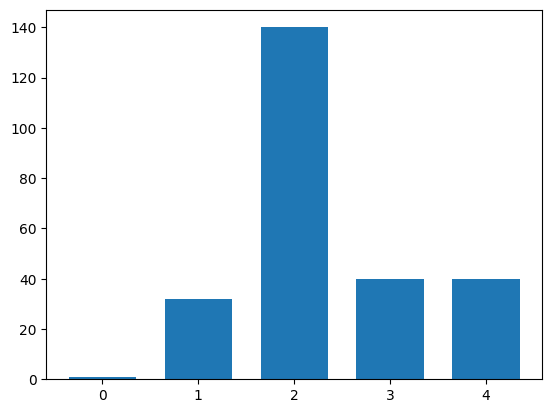

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,253.0,0.664032,1.251099,0.00,0.00,0.00,1.00,4.00
Pos2,253.0,0.774704,1.388956,0.00,0.00,0.00,1.00,4.00
Pos3,253.0,0.632411,1.258013,0.00,0.00,0.00,0.00,4.00
Pos4,253.0,0.557312,1.218930,0.00,0.00,0.00,0.00,4.00
Pos5,253.0,0.513834,1.121934,0.00,0.00,0.00,0.00,4.00
Pos6,253.0,0.430830,1.054167,0.00,0.00,0.00,0.00,4.00
Pos7,253.0,0.383399,1.007532,0.00,0.00,0.00,0.00,4.00
Pos8,253.0,0.533597,1.163200,0.00,0.00,0.00,0.00,4.00
Pos9,253.0,0.332016,0.904378,0.00,0.00,0.00,0.00,4.00
Pos10,253.0,0.284585,0.867193,0.00,0.00,0.00,0.00,4.00


/tmp/ipykernel_45021/1665130982.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe[['target']])


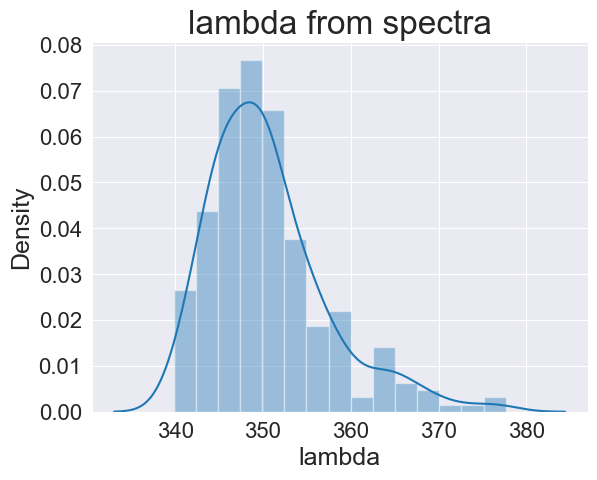

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

#sns.pairplot(dataframe[['target']], diag_kind='kde')
sns.set_style('darkgrid')
sns.distplot(dataframe[['target']])
plt.title('lambda from spectra',fontsize=24)
plt.xlabel('lambda',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()


In [ ]:
""" # remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose()) """

In [7]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,253.0,6.640316e-01,1.251099,0.000000,0.000000,0.000000,1.000000,4.000000
Pos2,253.0,7.747036e-01,1.388956,0.000000,0.000000,0.000000,1.000000,4.000000
Pos3,253.0,6.324111e-01,1.258013,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,253.0,5.573123e-01,1.218930,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,253.0,5.138340e-01,1.121934,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,253.0,4.308300e-01,1.054167,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,253.0,3.833992e-01,1.007532,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,253.0,5.335968e-01,1.163200,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,253.0,3.320158e-01,0.904378,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,253.0,2.845850e-01,0.867193,0.000000,0.000000,0.000000,0.000000,4.000000


In [35]:
# include all 0 and 1 substitutes into the training set
""" zero_df = dataset[ nsubs_df==0 ]
one_df = dataset[ nsubs_df==1 ]
rest_df = dataset[ nsubs_df>=2 ]

one_df = one_df.sample(frac=1,random_state=39).reset_index(drop=True)
rest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)
#train, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))])
#train = pd.concat([train,zero_df,one_df]) """

# include all 0, 1 and 2 substitutes into the training set
""" zero_df = dataset[ nsubs_df==0 ]
one_df = dataset[ nsubs_df==1 ]
two_df = dataset[ nsubs_df==2 ]
rest_df = dataset[ nsubs_df>=3 ]

rest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)
train, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))])
train = pd.concat([train,zero_df,one_df,two_df]) """

# include all 0 and 1 substitutes into the training set
# split 2-substitutes in two groups, half for training and half for rest
""" zero_df = dataset[ nsubs_df==0 ]
one_df = dataset[ nsubs_df==1 ]
two_df = dataset[ nsubs_df==2 ]
rest_df = dataset[ nsubs_df>=3 ]

two_df = two_df.sample(frac=1,random_state=29).reset_index(drop=True)
two_train, two_rest = np.split( two_df.sample(frac=1), [int(0.5*len(two_df))] )
rest_df = pd.concat([rest_df,two_rest])

rest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)
train, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))])
train = pd.concat([train,zero_df,one_df,two_train]) """

# only include 2, 3 and 4 substitus into the model
""" rest_df = dataset[ nsubs_df>=2 ]
rest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)
train, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))]) """


#print(len(train), 'training examples')
#print(len(val), 'validation examples')
#print(len(test), 'test examples')

' rest_df = dataset[ nsubs_df>=2 ]\nrest_df = rest_df.sample(frac=1,random_state=39).reset_index(drop=True)\ntrain, val, test = np.split(rest_df.sample(frac=1), [int(0.8*len(rest_df)), int(0.9*len(rest_df))]) '

In [8]:
# Preprocess to one-hot encode input features

data_ohe = dataset.copy()
data_ohe = data_ohe.drop(columns=['target'])

""" n_features = train_features.shape[1]
print(n_features)
n_features_onehot = 5*n_features

x_train = np.zeros((n_features,len(train_features)))
y_train = np.zeros((1,len(train_features)))
x_test = np.zeros((n_features,len(test_features)))
y_test = np.zeros((1,len(test_features))) """

ohe = OneHotEncoder(categories='auto')
data_ohe = ohe.fit_transform(data_ohe).toarray()
print(data_ohe.shape)
print(data_ohe[10])
print(ohe.categories_)

n_data = data_ohe.shape[0]
n_features = data_ohe.shape[1]
data = np.zeros((n_data,n_features+1))
print(data.shape)
data[:,0:n_features] = data_ohe[:,0:n_features]
data[:,n_features] = dataset['target'][:]
print(data[10,:])


(253, 77)
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0.]
[array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3]), array([0, 1, 2])]
(253, 78)
[1.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         1.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         1.
 0.         0.

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

x_data = data[:,0:n_features]
y_data = data[:,n_features]
data = shuffle(data, random_state=43)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=41)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

202 training examples
51 test and validation examples
(202, 77)
(202,)


In [ ]:
""" # Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=39).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets
train_ds = dataset.sample(frac=0.8, random_state=10)
test_ds = dataset.drop(train_ds.index)
print(len(train_ds), 'training examples')
print(len(test_ds), 'test and validation examples')

# split features and labels/targets
train_features = train_ds.copy()
test_features = test_ds.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')
print(train_features.shape)
print(train_labels.shape) """


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4992      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________


2023-04-03 17:20:45.787791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 17:20:45.839709: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-04-03 17:20:45.840176: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-03 17:20:45.841679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

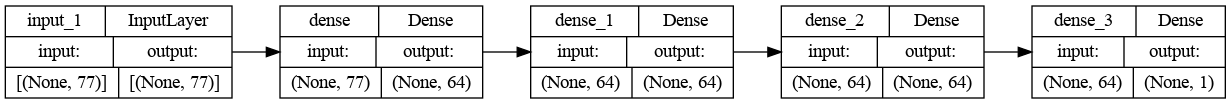

In [87]:
# Create the model architecture

#n_features = train_features.shape[1]
""" input = tf.keras.Input(shape=(n_features,))
model = tf.keras.Sequential()
model.add(input) """

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
#x = tf.keras.layers.Dense(16, activation="relu")(all_features)
#x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
""" model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu")) """

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

""" #x = tf.keras.layers.Dense(10)(x)
#output = tf.keras.layers.Dense(1)(x)
model.add(tf.keras.layers.Dense(1))

#model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR") """

In [10]:
# Define the hypermodel to optimize hyperparameters

def model_builder(hp):
  
  #n_features = train_features.shape[1]
  input = tf.keras.Input(shape=(n_features,))
  model = tf.keras.Sequential()
  model.add(input)

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  #initializer = tf.keras.initializers.GlorotNormal()
  initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=hp_units, activation=hp_activation,kernel_initializer=initializer))
  model.add(tf.keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_absolute_error')   

  return model

In [11]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=100,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='hypertuning_lambd_left_OneHotEnc_explore')

INFO:tensorflow:Reloading Tuner from ./Hypertuning/hypertuning_lambd_left_OneHotEnc_explore/tuner0.json


In [12]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
#tuner.search(train_features, train_labels, epochs=100, validation_split=0.1, batch_size=2, callbacks=[stop_early])
batch_size = 4
tuner.search(x_train, y_train, epochs=200, validation_split=0.2, batch_size=batch_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 1
n_units: 16
learning_rate: 0.01
activation_function: relu



In [13]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
epochs = 100
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

Epoch 1/100


2023-04-14 10:30:57.357659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 10:30:57.379612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-04-14 10:30:57.379634: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-14 10:30:57.379903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

46/46 - 0s - loss: 1.1047 - val_loss: 0.9367 - lr: 0.0100 - 366ms/epoch - 8ms/step
Epoch 2/100
46/46 - 0s - loss: 0.7475 - val_loss: 0.6897 - lr: 0.0100 - 41ms/epoch - 895us/step
Epoch 3/100
46/46 - 0s - loss: 0.6420 - val_loss: 0.7157 - lr: 0.0100 - 38ms/epoch - 823us/step
Epoch 4/100
46/46 - 0s - loss: 0.5958 - val_loss: 0.6177 - lr: 0.0100 - 37ms/epoch - 799us/step
Epoch 5/100
46/46 - 0s - loss: 0.5098 - val_loss: 0.5830 - lr: 0.0100 - 37ms/epoch - 802us/step
Epoch 6/100
46/46 - 0s - loss: 0.4519 - val_loss: 0.5514 - lr: 0.0100 - 36ms/epoch - 781us/step
Epoch 7/100
46/46 - 0s - loss: 0.3687 - val_loss: 0.4905 - lr: 0.0100 - 36ms/epoch - 777us/step
Epoch 8/100
46/46 - 0s - loss: 0.3536 - val_loss: 0.5532 - lr: 0.0100 - 36ms/epoch - 786us/step
Epoch 9/100
46/46 - 0s - loss: 0.3542 - val_loss: 0.4067 - lr: 0.0100 - 37ms/epoch - 810us/step
Epoch 10/100
46/46 - 0s - loss: 0.3026 - val_loss: 0.3979 - lr: 0.0100 - 42ms/epoch - 907us/step
Epoch 11/100
46/46 - 0s - loss: 0.3412 - val_loss: 0

Best epoch: 39


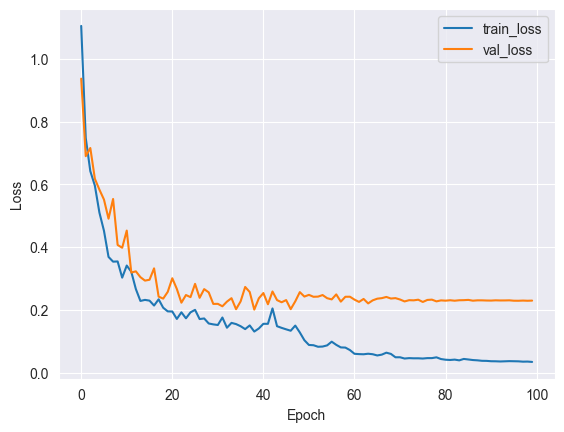

In [14]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

best_model = tuner.hypermodel.build(best_hps)

# Retrain the model
best_model.fit(x_train, y_train, epochs=best_epoch, batch_size=batch_size, validation_split=0.1,callbacks=[reduce_lr], verbose=2) """

In [15]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

2/2 [==============================] - 0s 2ms/step
(51, 1)
(51, 1)


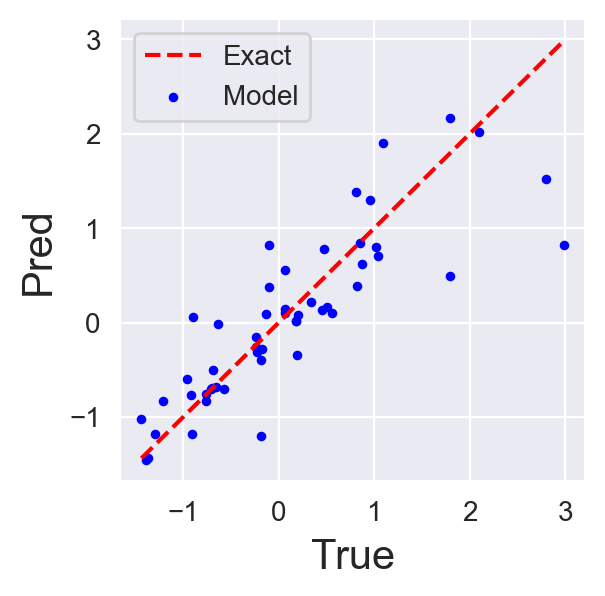

Test MAE: 0.3579311515842066


In [16]:
# Pred vs True values on test set 

#y_pred = model.predict(test_features)
y_pred = model.predict(x_test)
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

In [ ]:
""" # Pred vs True values on training set 

y_pred = model.predict(x_train)
y_pred.shape
y_true = np.zeros((len(y_train),1))
y_true[:,0] = y_train[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae)) """

In [ ]:
""" # Evaluate the model with non-normalized units

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE (non-normalized): "+str(test_mae)) """

In [31]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

7/7 [==============================] - 0s 616us/step


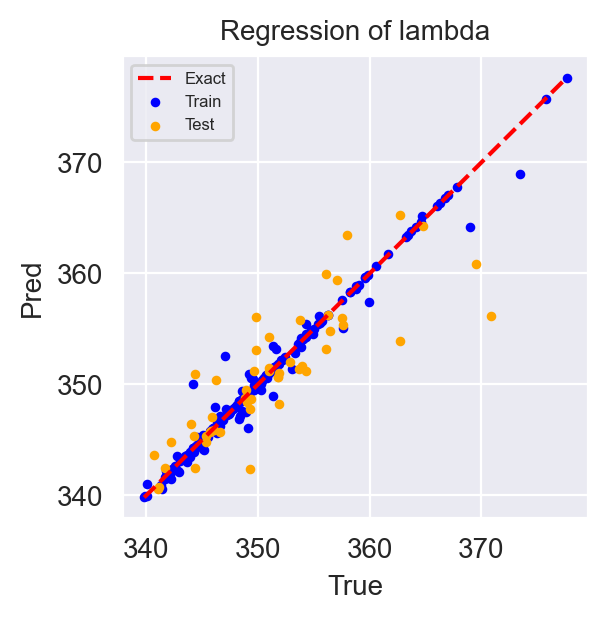

train MAE (non-normalized): 0.3713512156269345
test MAE (non-normalized): 2.4377952186734064


In [17]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(x_test)
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

y_pred_train = model.predict(x_train)
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

#y_pred_val = model.predict(val_ds)
#y_true_val = np.zeros((len(val['target']),1))
#y_true_val[:,0] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of lambda",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

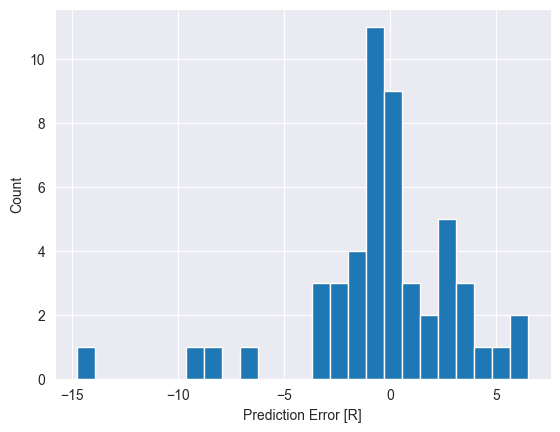

In [18]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')
